In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/ubuntu/anaconda3/envs/p38torch-pip/bin/python
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [2]:
#pip install ipykernel
#python -m ipykernel install --user --name [virtualEnv] --display-name "[displayKenrelName]"

In [3]:
#https://stackoverflow.com/questions/46767012/conda-list-shows-a-package-but-cannot-import-it

## Creating the Dataset

In [4]:
from torchvision.datasets import VOCSegmentation
from PIL import Image   
from torchvision.transforms.functional import to_tensor, to_pil_image

In [5]:
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            augmented= self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask']                  
            target[target>20]=0

        img= to_tensor(img)            
        target= torch.from_numpy(target).type(torch.long)
        return img, target

In [6]:
from albumentations import (
    HorizontalFlip,
    Compose,
    Resize,
    Normalize)

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
h,w=520,520

transform_train = Compose([ Resize(h,w),
                HorizontalFlip(p=0.5), 
                Normalize(mean=mean,std=std)])

transform_val = Compose( [ Resize(h,w),
                          Normalize(mean=mean,std=std)])            

In [7]:
%ls ../../../data/voc2012


VOCdevkit/  VOCtrainval_11-May-2012.tar


In [8]:
path2data="../../../data/voc2012"    
train_ds=myVOCSegmentation(path2data, 
                year='2012', 
                image_set='train', 
                download=True, 
                transforms=transform_train) 
print(len(train_ds)) 

Using downloaded and verified file: ../../../data/voc2012/VOCtrainval_11-May-2012.tar
Extracting ../../../data/voc2012/VOCtrainval_11-May-2012.tar to ../../../data/voc2012
1464


In [9]:
val_ds=myVOCSegmentation(path2data, 
                year='2012', 
                image_set='val', 
                download=False, 
                transforms=transform_val)
print(len(val_ds)) 

1449


In [10]:
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline
np.random.seed(0)
num_classes=21
COLORS = np.random.randint(0, 2, size=(num_classes+1, 3),dtype="uint8")

In [11]:
def show_img_target(img, target):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        target=target.numpy()
    for ll in range(num_classes):
        mask=(target==ll)
        img=mark_boundaries(np.array(img) , 
                            mask,
                            outline_color=COLORS[ll],
                            color=COLORS[ll])
    plt.imshow(img)

In [12]:
def re_normalize (x, mean = mean, std= std):
    x_r= x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        x_r [c] *= std_c
        x_r [c] += mean_c
    return x_r

In [13]:
img, mask = train_ds[6]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6400)
torch.Size([520, 520]) torch.LongTensor tensor(4)


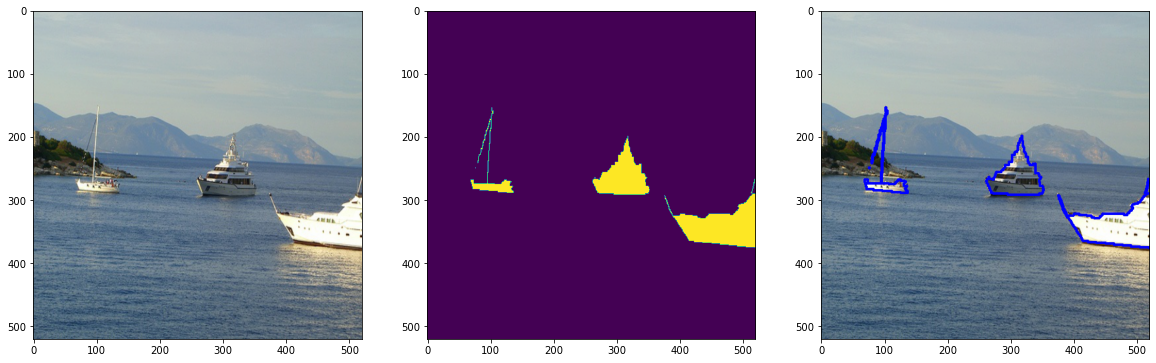

In [14]:
plt.figure(figsize=(20,20))

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)
    

In [15]:
img, mask = val_ds[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6226)
torch.Size([520, 520]) torch.LongTensor tensor(1)


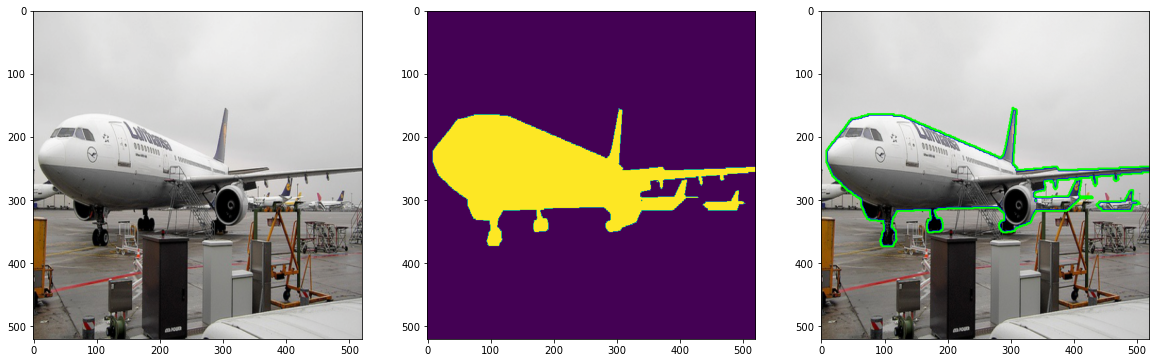

In [16]:
plt.figure(figsize=(20,20))

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

### Creating DataLoader

In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False) 

In [18]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 3, 520, 520]) torch.float32
torch.Size([4, 520, 520]) torch.int64


In [19]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 3, 520, 520]) torch.float32
torch.Size([8, 520, 520]) torch.int64


# Creating the Model

In [20]:
from torchvision.models.segmentation import deeplabv3_resnet101
import torch

In [21]:
model=deeplabv3_resnet101(pretrained=True, num_classes=21)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [23]:
#https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/28712742#comment102640654_28712742
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import torchsummary

In [28]:
#torchsummary(model)
# TypeError: 'module' object is not callable

In [29]:
#print(model)

## Deploying the Model

In [30]:
from torch import nn

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        yb_pred = model(xb.to(device))
        yb_pred = yb_pred["out"].cpu()
        print(yb_pred.shape)    
        yb_pred = torch.argmax(yb_pred,axis=1)
        break
print(yb_pred.shape)

torch.Size([8, 21, 520, 520])
torch.Size([8, 520, 520])


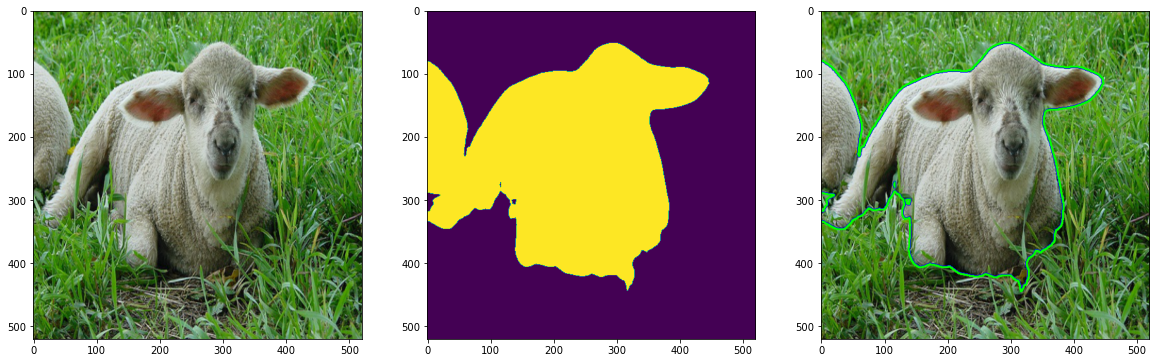

In [31]:
plt.figure(figsize=(20,20))

#n=4
n=5
img, mask= xb[n], yb_pred[n]
img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

## Define Loss Function

In [32]:
from torch import nn
criterion = nn.CrossEntropyLoss(reduction="sum")

## Optimizer

In [33]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-6)

In [34]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), None

In [35]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [36]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=1e-06


## Training the Model

In [37]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)["out"]
        loss_b, _ = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    return loss, None

In [38]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        


In [39]:
import os
opt = optim.Adam(model.parameters(), lr=1e-6)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"sanity_weights.pt",
}

model, loss_hist, _ = train_val(model, params_train)

Epoch 0/99, current lr=1e-06
Copied best model weights!
train loss: 228.375897
val loss: 227.474163
----------
Epoch 1/99, current lr=1e-06
Copied best model weights!
train loss: 140.138234
val loss: 226.063039
----------
Epoch 2/99, current lr=1e-06
Copied best model weights!
train loss: 211.112470
val loss: 221.990446
----------
Epoch 3/99, current lr=1e-06
train loss: 108.936603
val loss: 227.401872
----------
Epoch 4/99, current lr=1e-06
train loss: 316.468195
val loss: 232.728347
----------
Epoch 5/99, current lr=1e-06
train loss: 76.821855
val loss: 234.112384
----------
Epoch 6/99, current lr=1e-06
train loss: 193.550098
val loss: 231.051350
----------
Epoch 7/99, current lr=1e-06
train loss: 401.913678
val loss: 234.172878
----------
Epoch 8/99, current lr=1e-06
train loss: 89.864562
val loss: 226.463423
----------
Epoch 9/99, current lr=1e-06
train loss: 130.231024
val loss: 222.657242
----------
Epoch 10/99, current lr=1e-06
train loss: 122.161907
val loss: 229.264493
-------

train loss: 187.514728
val loss: 240.963445
----------
Epoch 91/99, current lr=2.5e-07
train loss: 144.848371
val loss: 229.813190
----------
Epoch 92/99, current lr=2.5e-07
train loss: 114.101296
val loss: 228.599573
----------
Epoch 93/99, current lr=2.5e-07
train loss: 358.430029
val loss: 224.290696
----------
Epoch 94/99, current lr=2.5e-07
train loss: 128.018443
val loss: 236.616352
----------
Epoch 95/99, current lr=2.5e-07
train loss: 1503.036885
val loss: 245.472071
----------
Epoch 96/99, current lr=2.5e-07
train loss: 706.822319
val loss: 241.990295
----------
Epoch 97/99, current lr=2.5e-07
train loss: 127.480181
val loss: 247.211353
----------
Epoch 98/99, current lr=2.5e-07
train loss: 219.967853
val loss: 242.142857
----------
Epoch 99/99, current lr=2.5e-07
train loss: 180.190958
val loss: 241.809157
----------


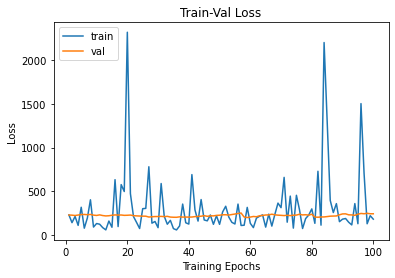

In [40]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()